# Import Libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
from jupyterthemes import jtplot
jtplot.style(theme = 'monokai', context = 'notebook', ticks = True, grid = False) 
pd.set_option('display.max_columns', 100)

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import xgboost as xgb

# Import Dataset

In [4]:
# Explore the dataframe
df = pd.read_csv('cervical_cancer.csv')
df.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,IUD (years),STDs,STDs (number),STDs:condylomatosis,STDs:cervical condylomatosis,STDs:vaginal condylomatosis,STDs:vulvo-perineal condylomatosis,STDs:syphilis,STDs:pelvic inflammatory disease,STDs:genital herpes,STDs:molluscum contagiosum,STDs:AIDS,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0
2,34,1.0,?,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0


# Preprocess Dataset

In [5]:
# Get dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Age                                 858 non-null    int64 
 1   Number of sexual partners           858 non-null    object
 2   First sexual intercourse            858 non-null    object
 3   Num of pregnancies                  858 non-null    object
 4   Smokes                              858 non-null    object
 5   Smokes (years)                      858 non-null    object
 6   Smokes (packs/year)                 858 non-null    object
 7   Hormonal Contraceptives             858 non-null    object
 8   Hormonal Contraceptives (years)     858 non-null    object
 9   IUD                                 858 non-null    object
 10  IUD (years)                         858 non-null    object
 11  STDs                                858 non-null    object

In [6]:
# Replace missing values ? with NaN
df.replace('?',np.nan,inplace=True)

In [7]:
# Change columns data type
df = df.apply(pd.to_numeric)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 858 non-null    int64  
 1   Number of sexual partners           832 non-null    float64
 2   First sexual intercourse            851 non-null    float64
 3   Num of pregnancies                  802 non-null    float64
 4   Smokes                              845 non-null    float64
 5   Smokes (years)                      845 non-null    float64
 6   Smokes (packs/year)                 845 non-null    float64
 7   Hormonal Contraceptives             750 non-null    float64
 8   Hormonal Contraceptives (years)     750 non-null    float64
 9   IUD                                 741 non-null    float64
 10  IUD (years)                         741 non-null    float64
 11  STDs                                753 non-n

<AxesSubplot:>

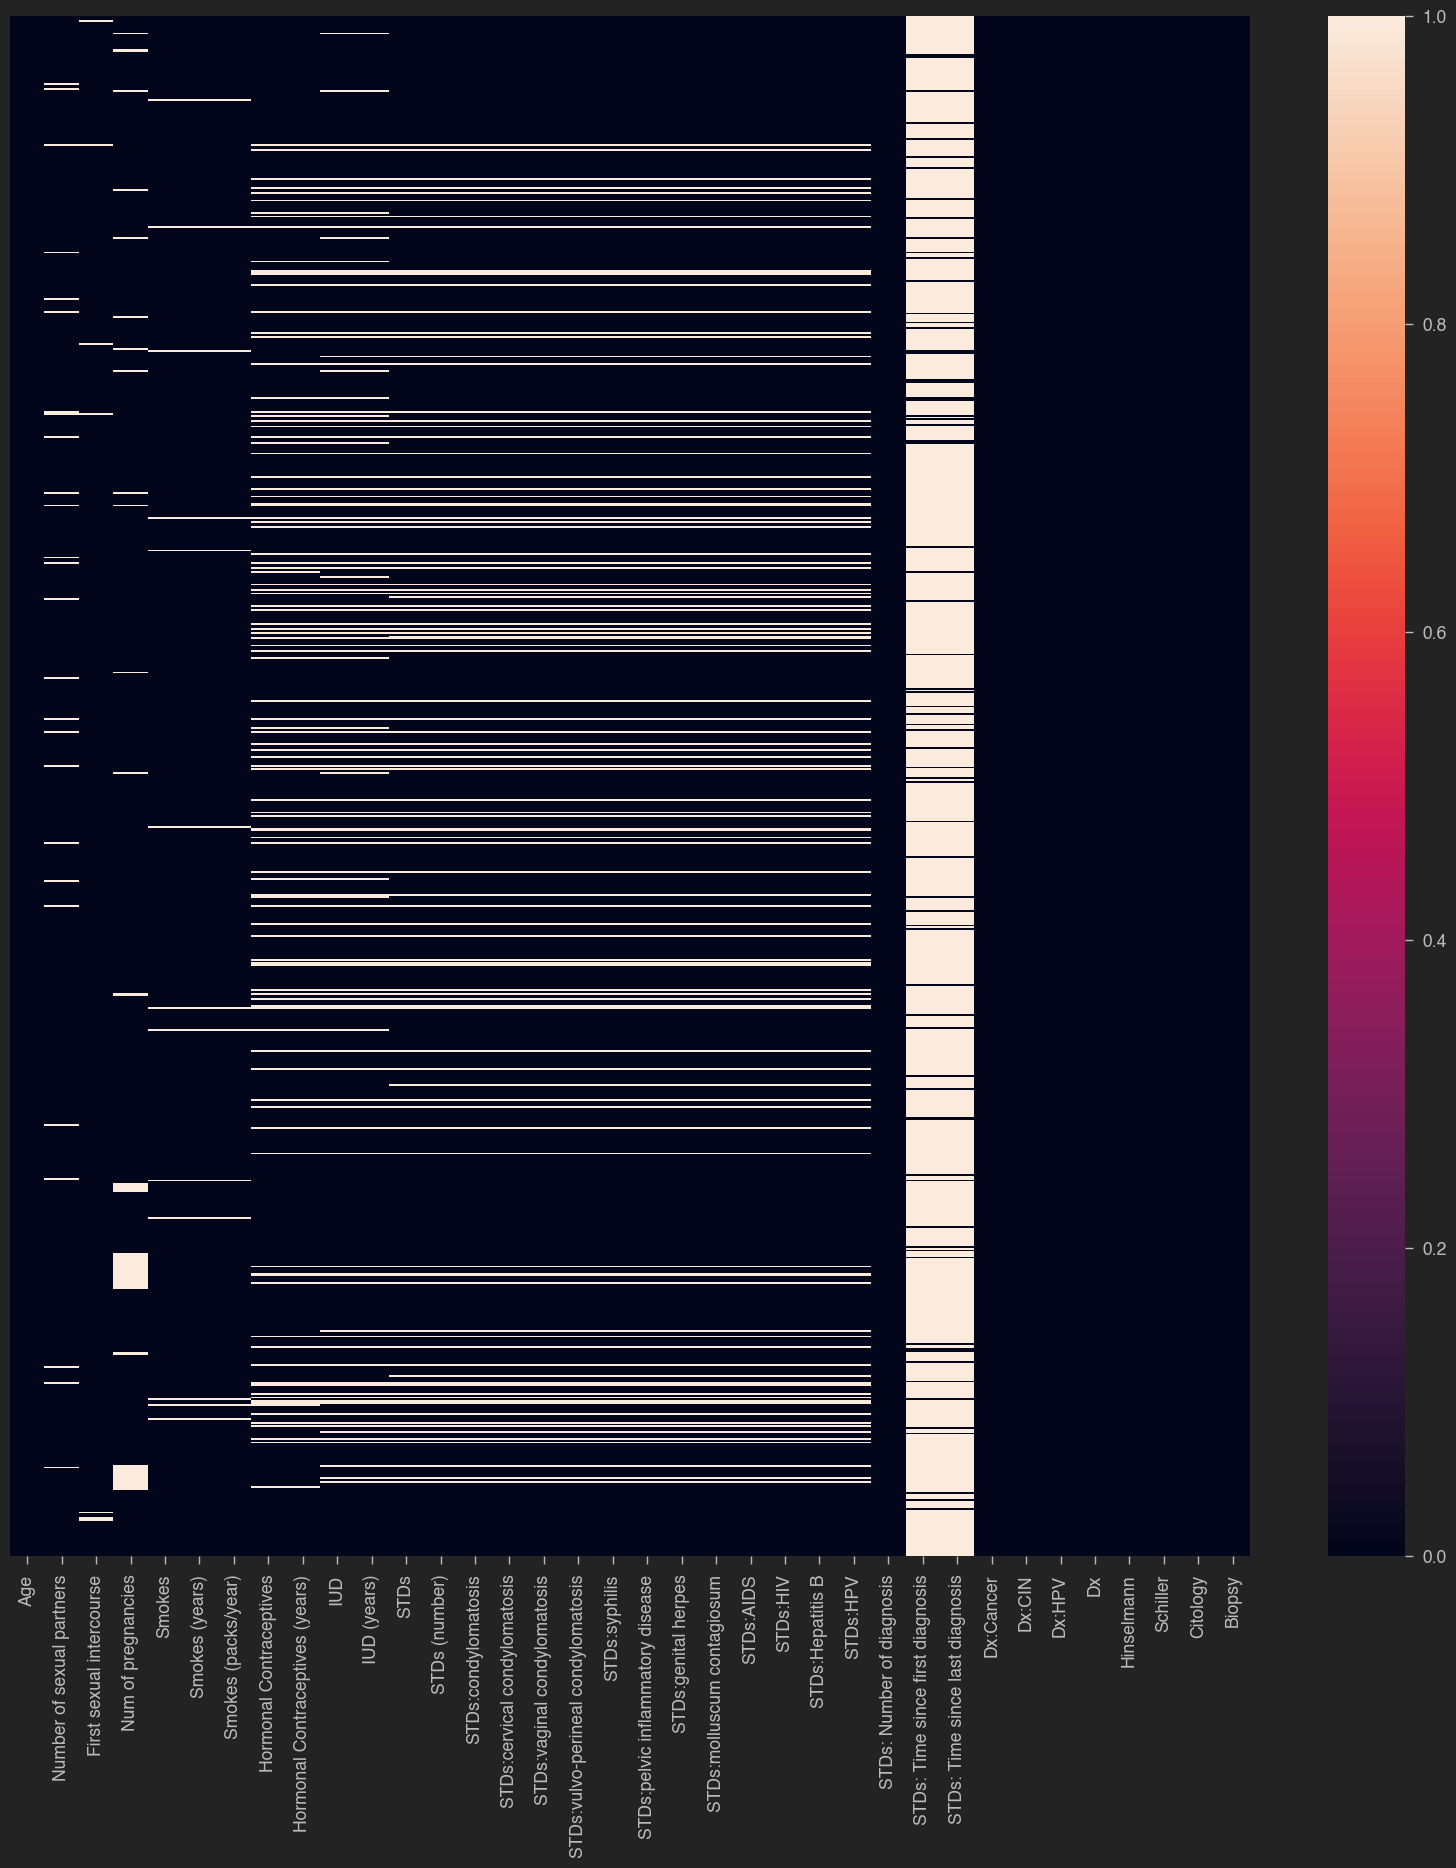

In [8]:
# Plot heatmap for missing values
df.isnull().sum()
plt.figure(figsize=(20,20))
sns.heatmap(df.isnull(), yticklabels=False)

In [9]:
# Since STDs: Time since first diagnosis and STDs: Time since last diagnosis have more than 80% missing values 
# we can drop them
df.drop(['STDs: Time since first diagnosis', 'STDs: Time since last diagnosis'], axis=1, inplace=True)

In [10]:
# Check amount of missing values in each column
df.isnull().sum()

Age                                     0
Number of sexual partners              26
First sexual intercourse                7
Num of pregnancies                     56
Smokes                                 13
Smokes (years)                         13
Smokes (packs/year)                    13
Hormonal Contraceptives               108
Hormonal Contraceptives (years)       108
IUD                                   117
IUD (years)                           117
STDs                                  105
STDs (number)                         105
STDs:condylomatosis                   105
STDs:cervical condylomatosis          105
STDs:vaginal condylomatosis           105
STDs:vulvo-perineal condylomatosis    105
STDs:syphilis                         105
STDs:pelvic inflammatory disease      105
STDs:genital herpes                   105
STDs:molluscum contagiosum            105
STDs:AIDS                             105
STDs:HIV                              105
STDs:Hepatitis B                  

In [11]:
# Replace missing values with mean
df.fillna(df.mode().iloc[0],inplace=True)

<AxesSubplot:>

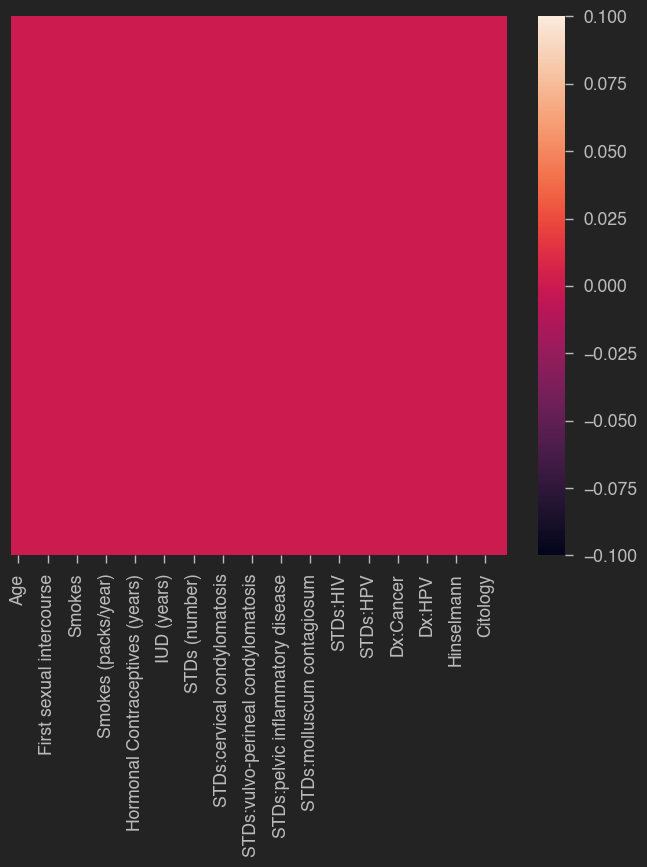

In [12]:
# Nan heatmap
sns.heatmap(df.isnull(), yticklabels=False)

In [13]:
# Check for duplicate rows
print(df.shape)
print('duplicated rows', df.duplicated().sum())
df.drop_duplicates(inplace=True)
print(df.shape)


(858, 34)
duplicated rows 28
(830, 34)


# Data Visualizations

In [14]:
# Countplot function
def grafica_countplot(dataframe, columna):
    countplot = sns.countplot(data=dataframe, x=columna, order=dataframe[columna].value_counts(ascending=False).index)
    abs_values = dataframe[columna].value_counts(ascending=False)
    rel_values = np.round(dataframe[columna].value_counts(ascending=False, normalize=True).values * 100)
    #lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]
    countplot.bar_label(container=countplot.containers[0], labels=rel_values)

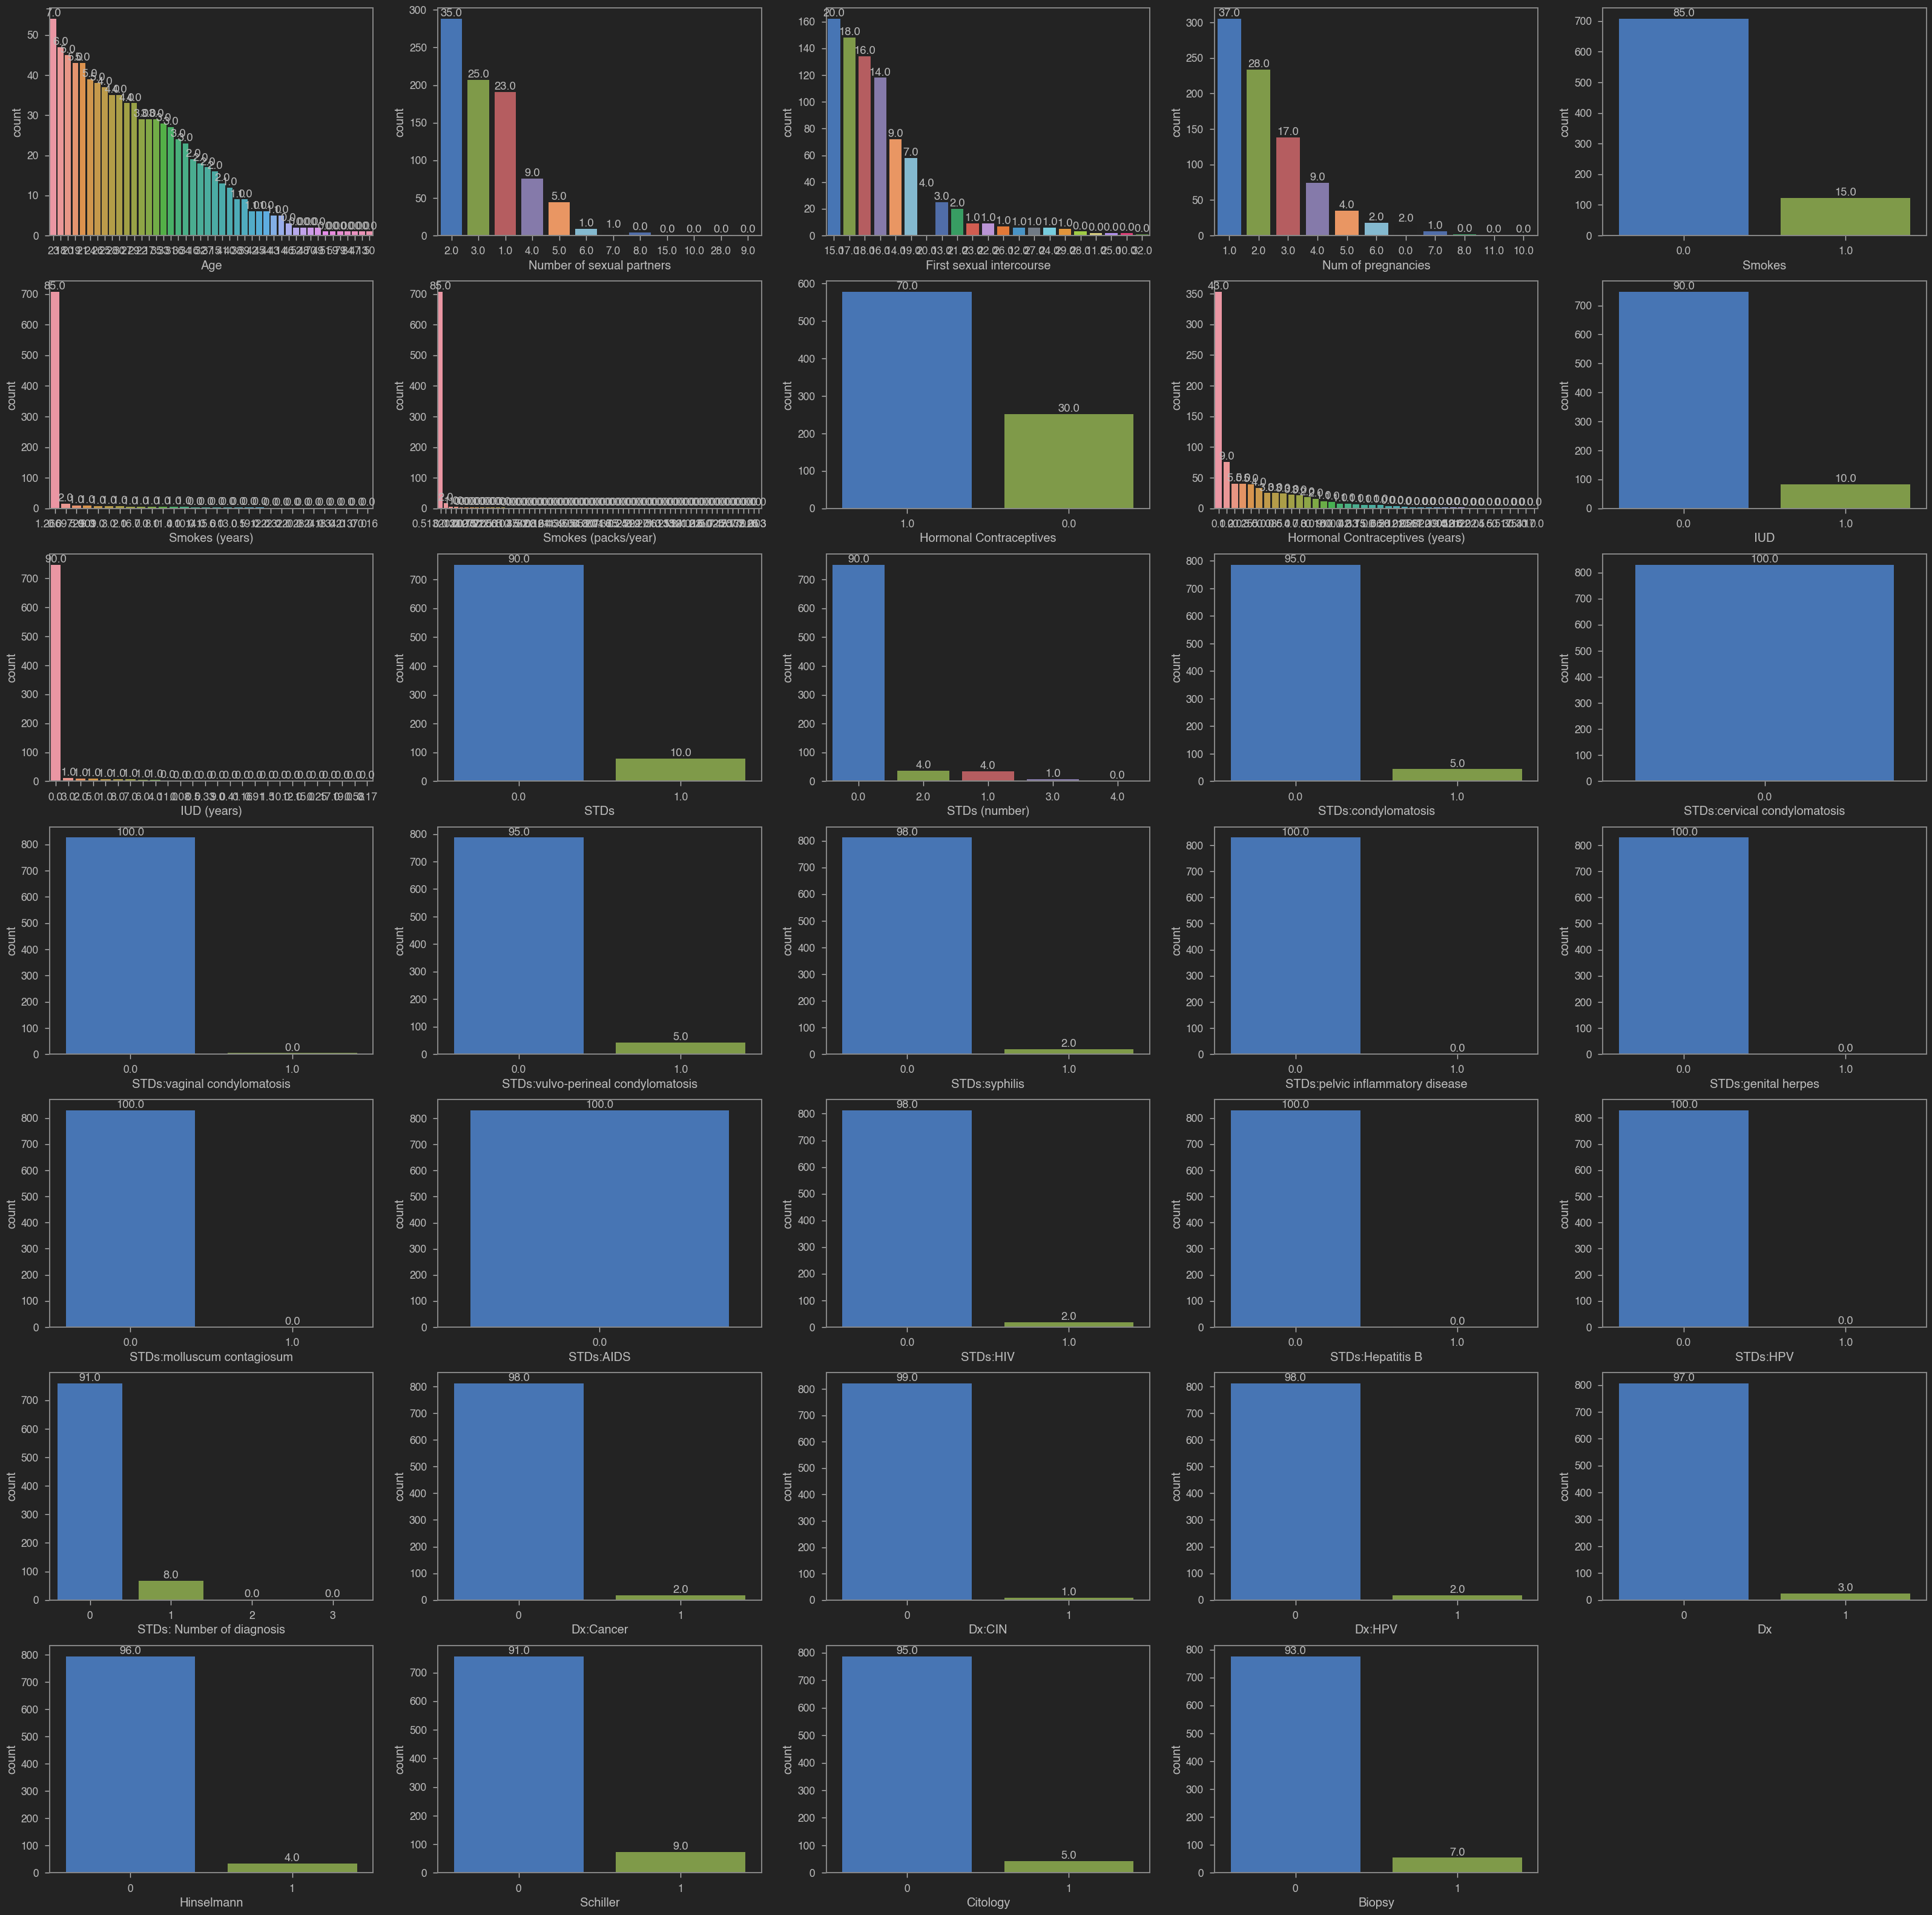

In [15]:
plt.figure(figsize=(40,40))
for i, col in enumerate(df.columns):
    plt.subplot(7, 5, i+1)
    grafica_countplot(df, col)

In [16]:
# Remove columns that do not contribute to the Target variable
df.drop(['STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis', 'STDs:syphilis', 
         'STDs:pelvic inflammatory disease', 'STDs:AIDS', 'Dx:Cancer', 'Dx:CIN', 
         'STDs:genital herpes', 'Dx:HPV','STDs:molluscum contagiosum', 'Dx', 'STDs:HIV', 'STDs:Hepatitis B', 'STDs:HPV'], axis=1, inplace=True)

/var/folders/35/yy1zp7sj41n7mxlrty00ptp80000gn/T/ipykernel_1494/1137489116.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))


['Smokes (years)', 'Smokes (packs/year)', 'IUD (years)', 'STDs (number)', 'STDs:condylomatosis', 'STDs:vulvo-perineal condylomatosis', 'STDs: Number of diagnosis', 'Biopsy']


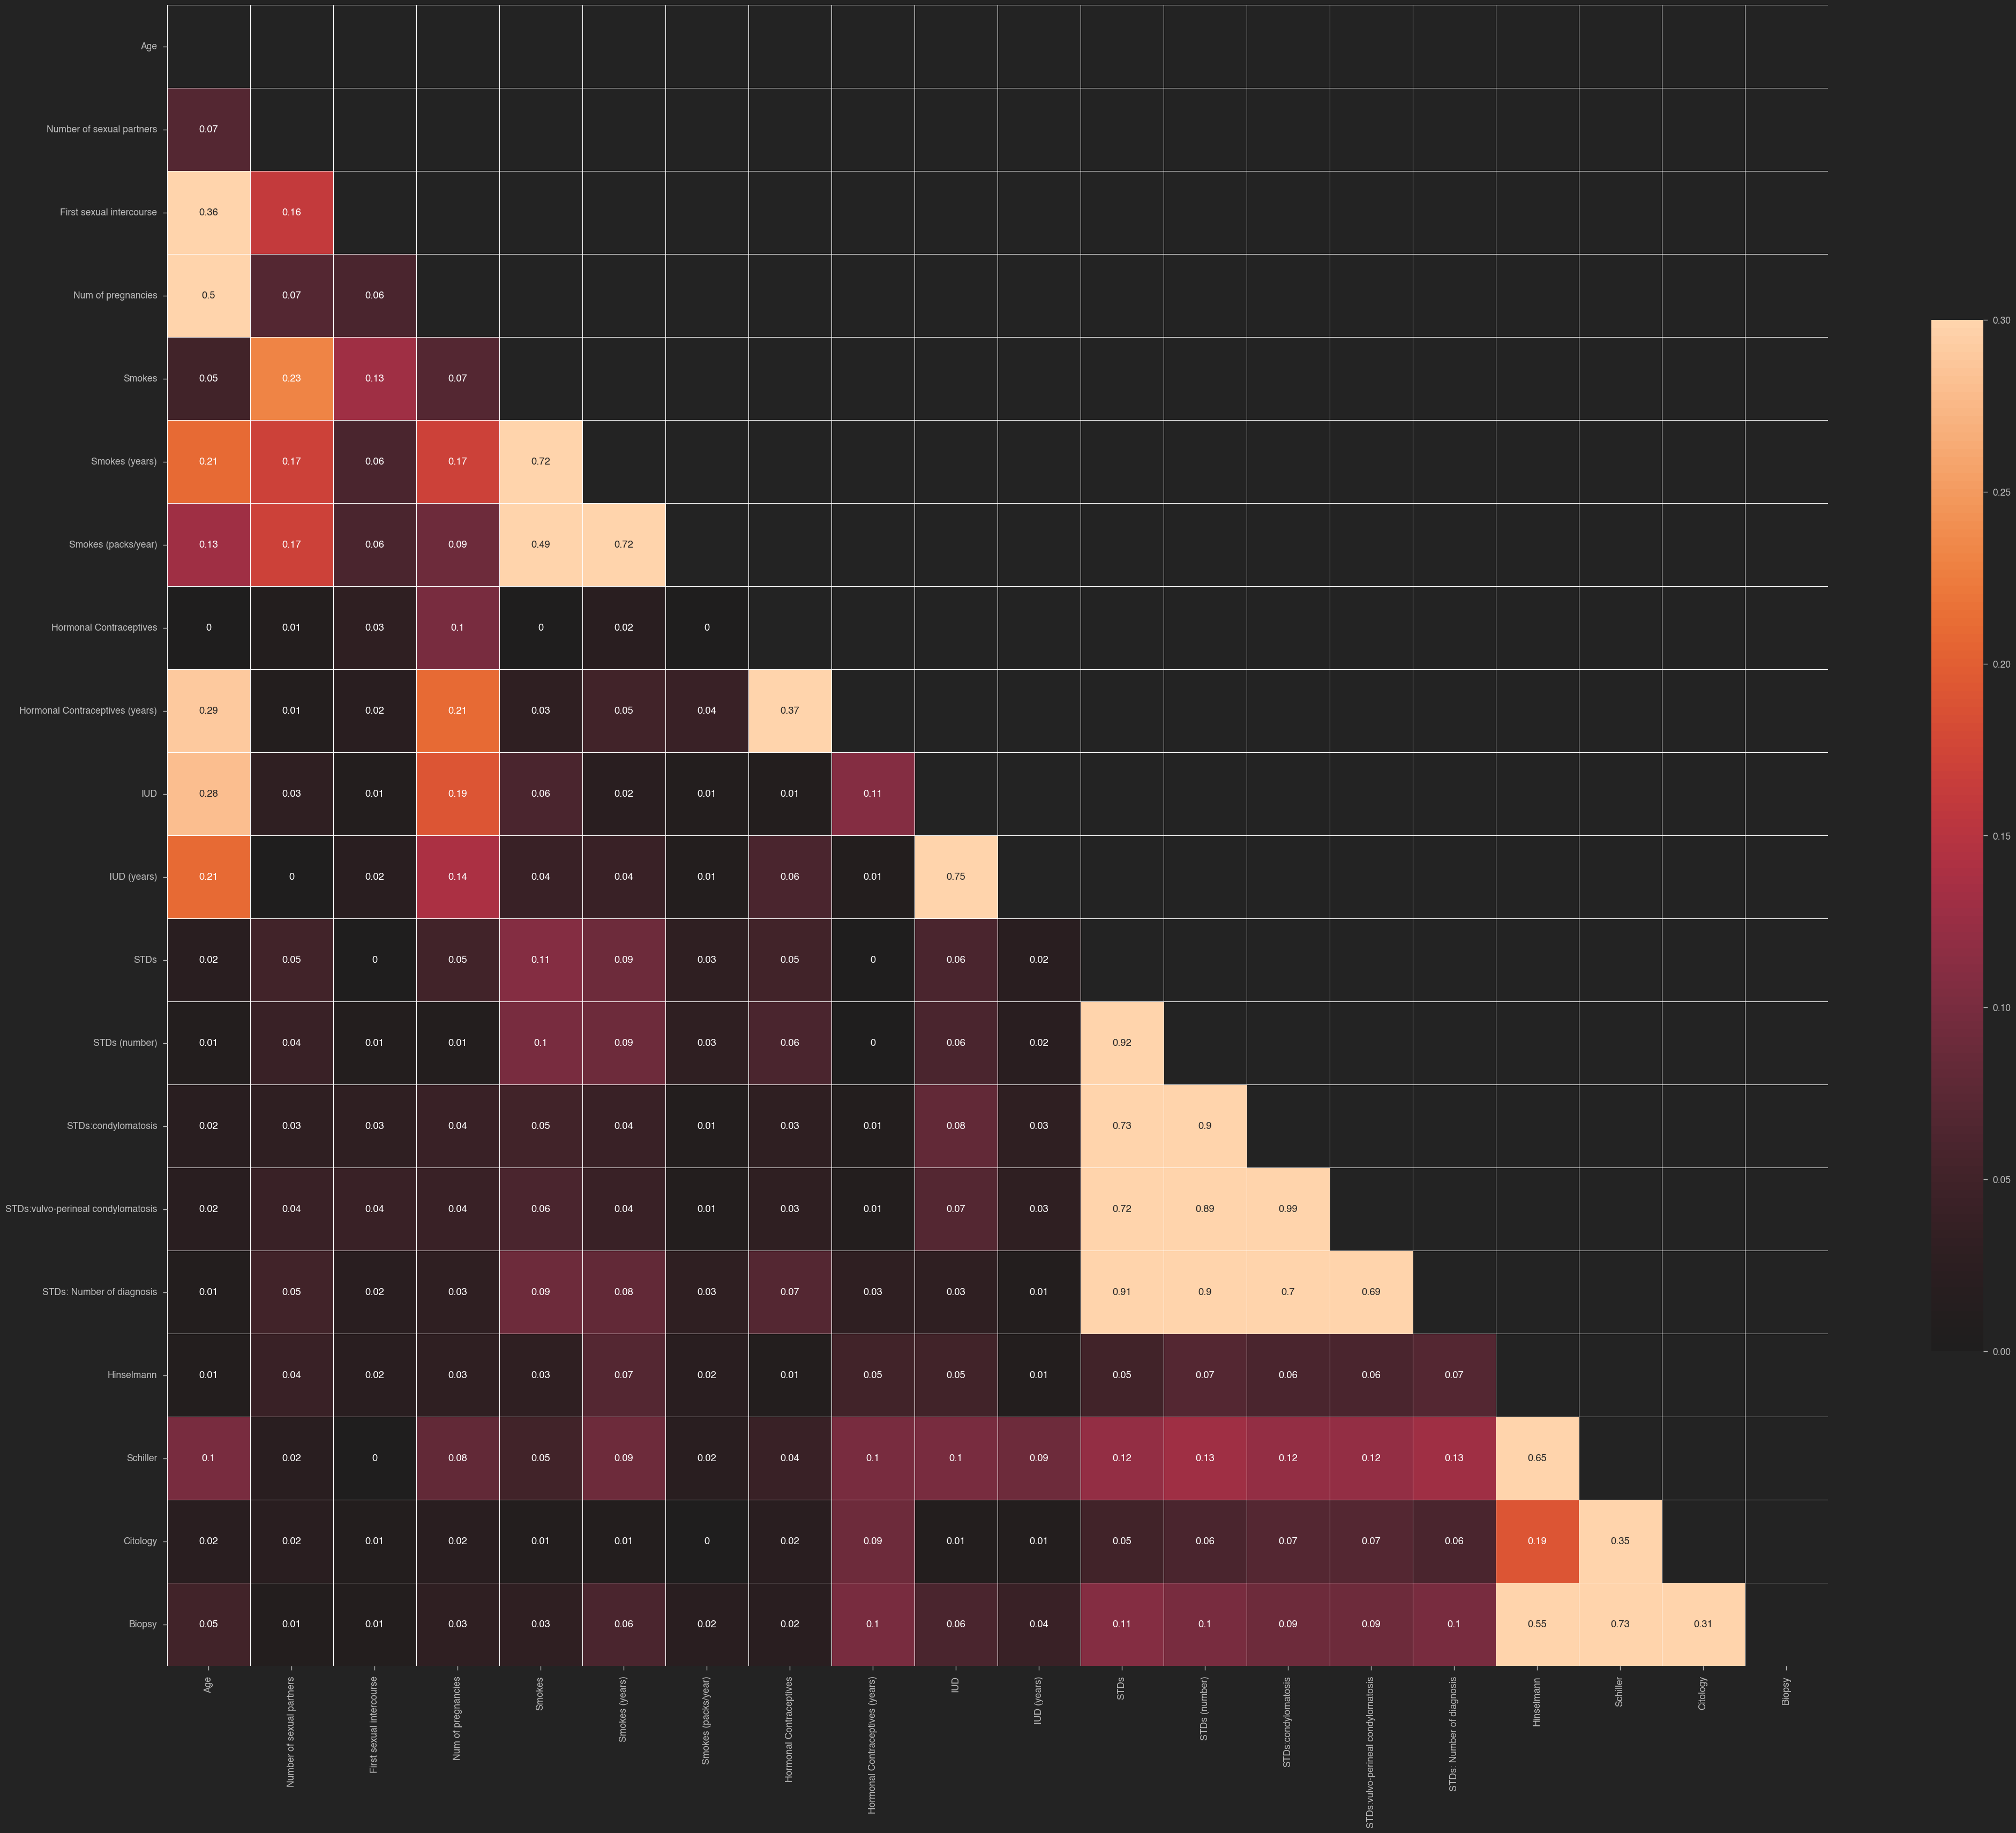

In [17]:
# Plot the correlation matrix
corr = df.corr().abs()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(50, 50))
#cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(round(corr,2), mask=mask, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
s = corr.unstack()
so = s.sort_values(kind="quicksort")
so.to_excel("D:\Descargas\correlacion.xlsx")
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.70)]
print(to_drop)
plt.show()

array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Number of sexual partners'}>,
        <AxesSubplot:title={'center':'First sexual intercourse'}>,
        <AxesSubplot:title={'center':'Num of pregnancies'}>],
       [<AxesSubplot:title={'center':'Smokes'}>,
        <AxesSubplot:title={'center':'Smokes (years)'}>,
        <AxesSubplot:title={'center':'Smokes (packs/year)'}>,
        <AxesSubplot:title={'center':'Hormonal Contraceptives'}>],
       [<AxesSubplot:title={'center':'Hormonal Contraceptives (years)'}>,
        <AxesSubplot:title={'center':'IUD'}>,
        <AxesSubplot:title={'center':'IUD (years)'}>,
        <AxesSubplot:title={'center':'STDs'}>],
       [<AxesSubplot:title={'center':'STDs (number)'}>,
        <AxesSubplot:title={'center':'STDs:condylomatosis'}>,
        <AxesSubplot:title={'center':'STDs:vulvo-perineal condylomatosis'}>,
        <AxesSubplot:title={'center':'STDs: Number of diagnosis'}>],
       [<AxesSubplot:title={'center'

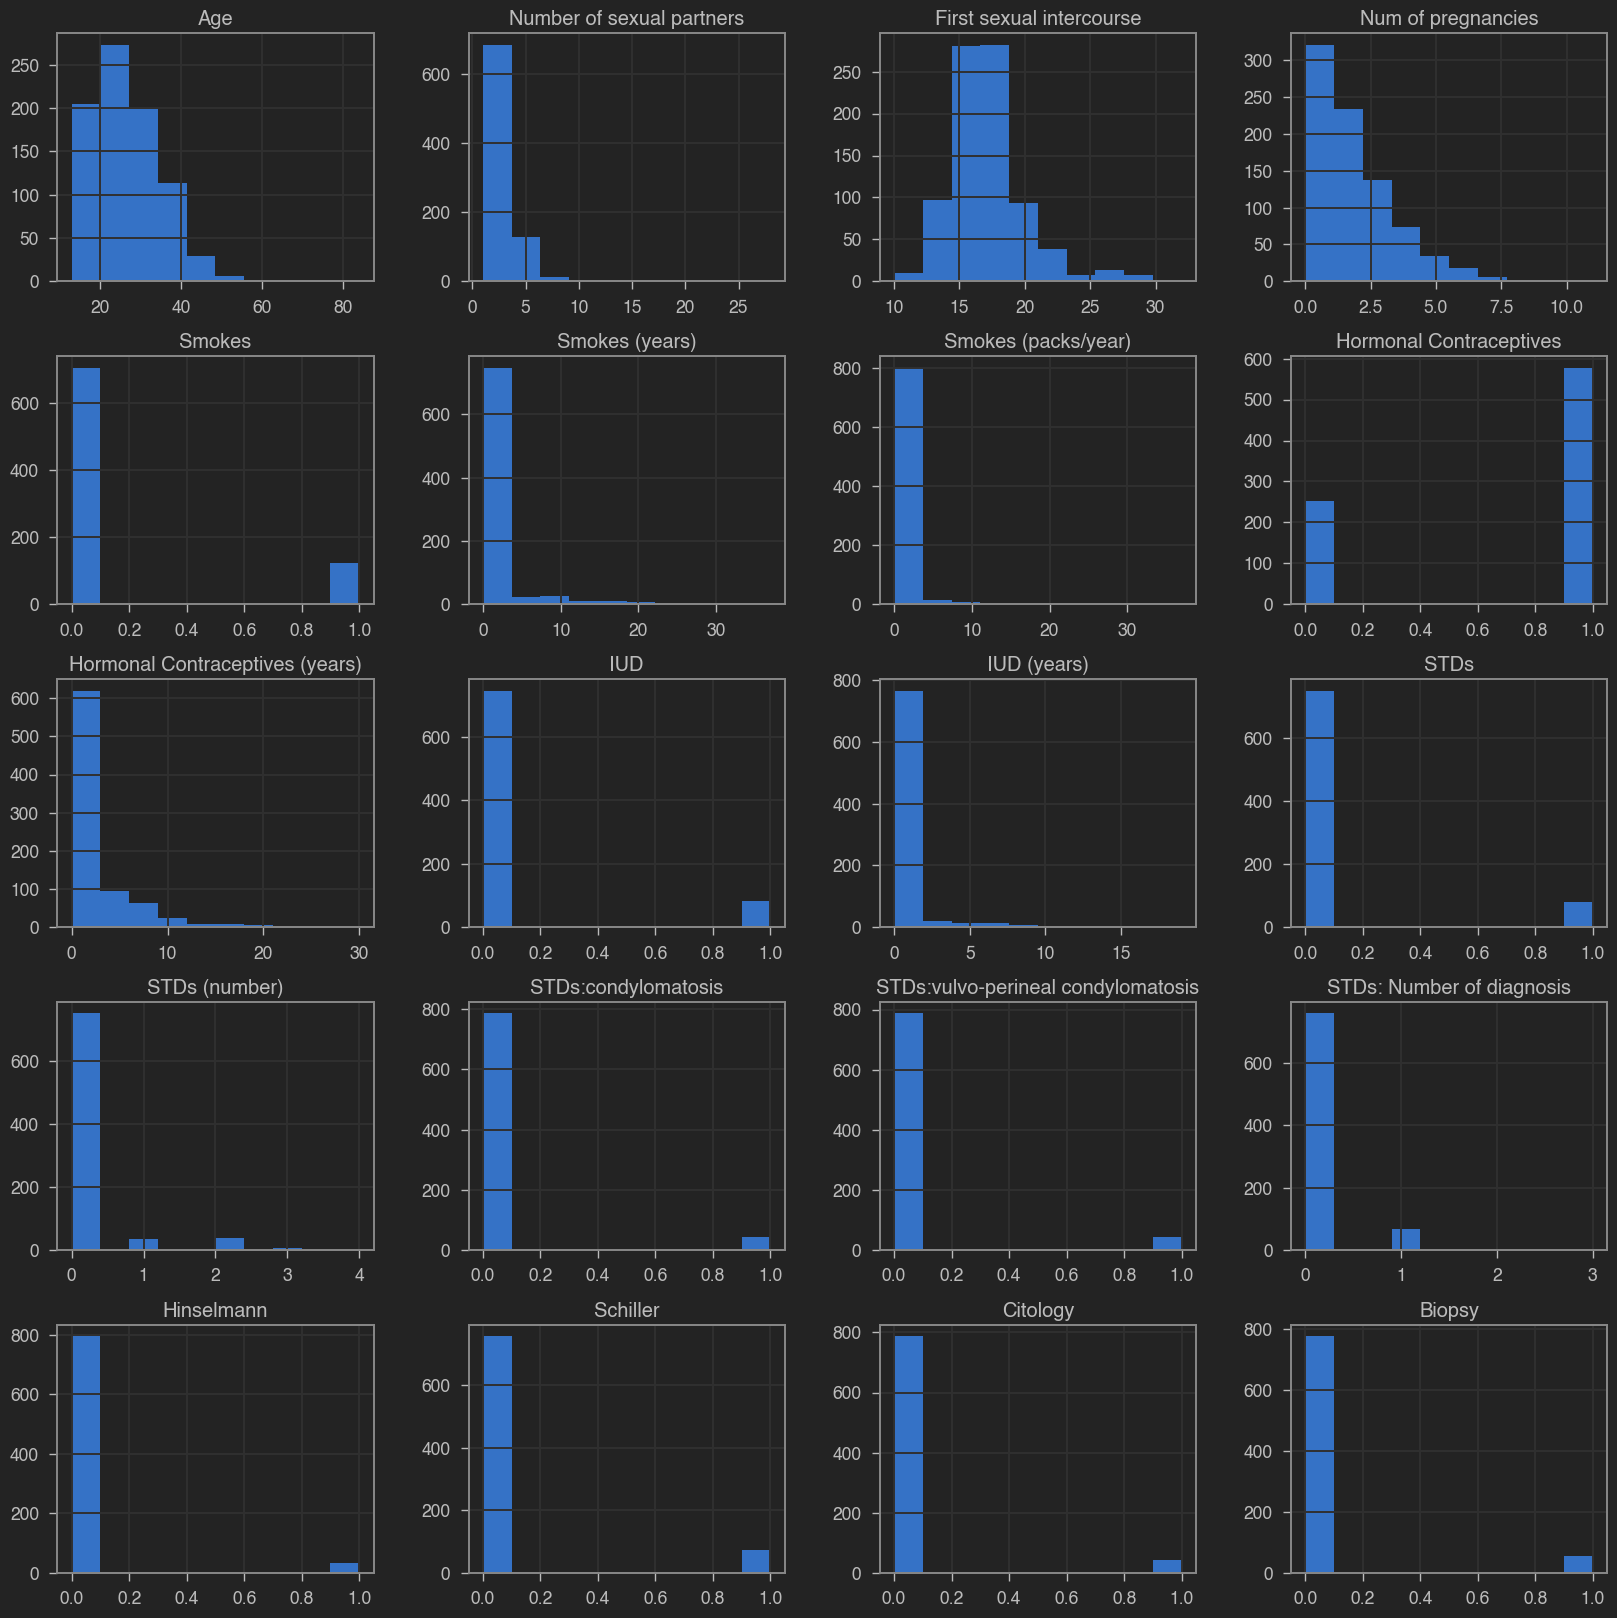

In [18]:
# Plot histograms of all dataframe
df.hist(figsize=(20,20))

# Prepare Data before training

[Text(0, 0, '776'), Text(0, 0, '54')]

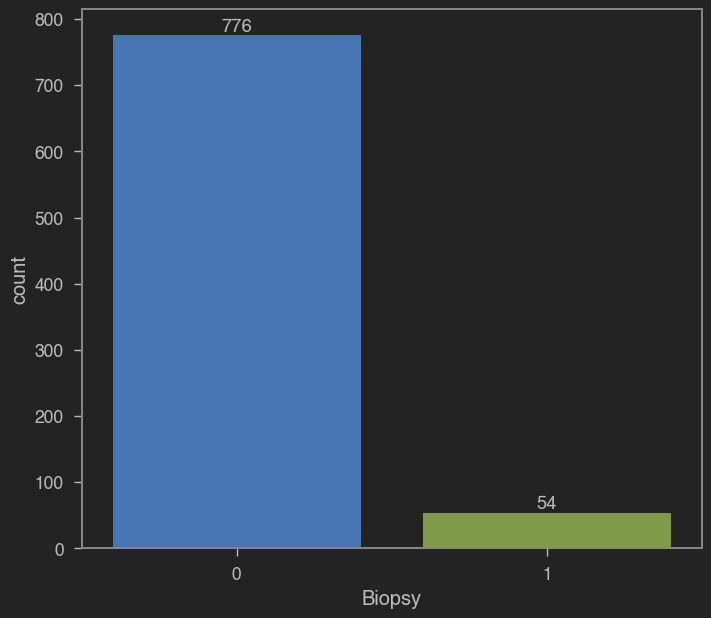

In [19]:
# We need to take into account that we have an imbalance target varible
countplot = sns.countplot(data=df, x='Biopsy')
countplot.bar_label(countplot.containers[0])

In [20]:
# Separe data in X (input variables) and y (target variable)
X = df.drop(['Biopsy'], axis=1)
y = df['Biopsy']
X = np.array(X).astype('float32')
y = np.array(y).astype('float32')

In [21]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [22]:
# Pipeline function to standarize/normalize data, search for parameters and generate trained model
def generar_modelo(escalador, modelo, X_train, y_train, params={}, scoring='accuracy'):
    escalador_modelo = escalador()
    modelo_usar = modelo()

    pipeline = Pipeline(steps=[('escalador', escalador_modelo), ('modelo', modelo_usar)])

    search_pipeline = GridSearchCV(pipeline, param_grid=params, scoring=scoring)


    search_pipeline.fit(X_train, y_train)

    return search_pipeline.best_estimator_

In [23]:
# Function to see model results with test data
def probar_modelo(modelo, X_test, y_test):
    y_pred = modelo.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(15,5))
    ax = plt.subplot(1, 2, 1)
    ax.plot([0,1], [0,1], 'k--')
    ax.plot(fpr, tpr)
    ax.set_title(f'AUC score is {roc_auc_score(y_test, y_pred): .2f}')

    ax = plt.subplot(1, 2, 2)
    sns.heatmap(cm, cmap='Blues', annot=True)
    ax.set_title('Matriz de confusion')
    ax.set_xlabel('Prediccion')
    
    display(pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)))

# Model

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.954248,0.769231,0.939759,0.861740,0.935301
recall,0.979866,0.588235,0.939759,0.784051,0.939759
f1-score,0.966887,0.666667,0.939759,0.816777,0.936142
support,149.000000,17.000000,0.939759,166.000000,166.000000


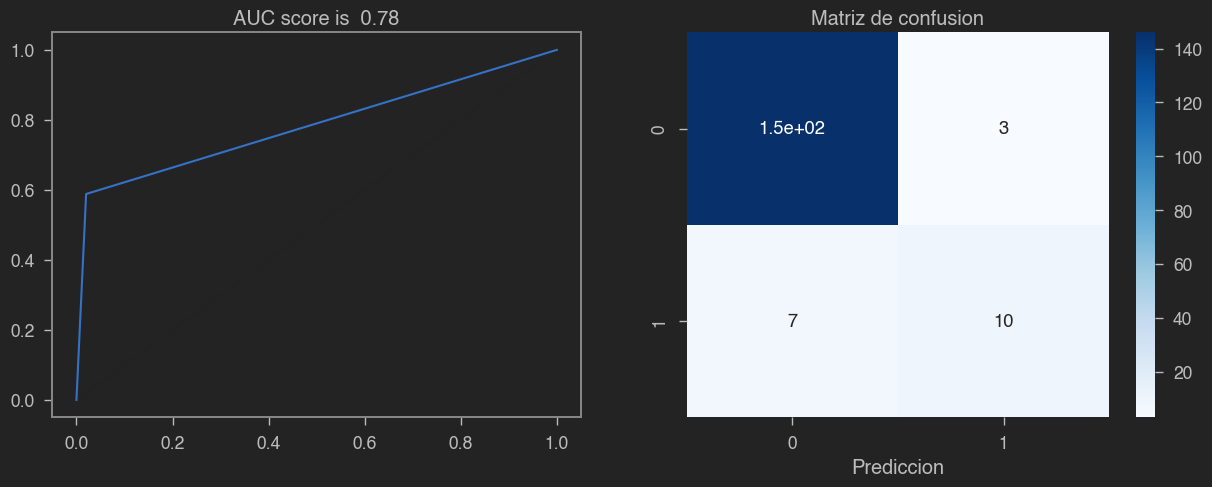

In [27]:
# First XGBoost model without tuning model for imbalaced target
params = {
    'modelo__eta': (0.05, 0.1, 0.3, 0.5),
    'modelo__gamma': (0, 1, 5, 7),
    'modelo__max_depth': (1, 6, 9, 10, 20, 50)

}
xgboost = generar_modelo(StandardScaler, xgb.XGBClassifier, X_train, y_train, params=params, scoring='recall')
probar_modelo(xgboost, X_test, y_test)

In [42]:
np.unique(y_train, return_counts=True)

(array([0., 1.], dtype=float32), array([627,  37]))

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.986395,0.789474,0.963855,0.887934,0.966228
recall,0.973154,0.882353,0.963855,0.927754,0.963855
f1-score,0.979730,0.833333,0.963855,0.906532,0.964737
support,149.000000,17.000000,0.963855,166.000000,166.000000


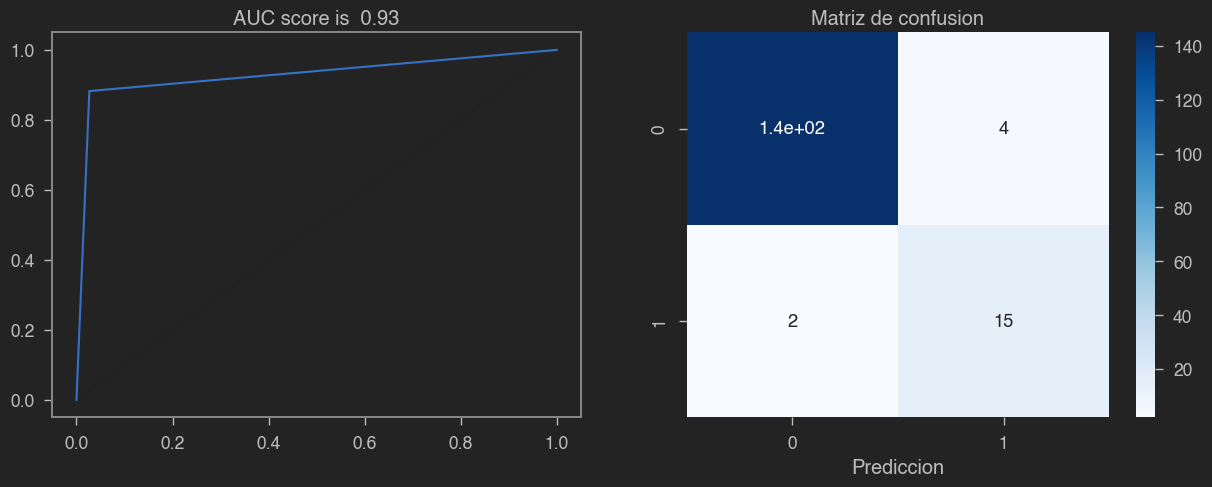

In [48]:
# Second XGBoost model tuned for imbalance target

#The XGBoost documentation suggests a fast way to estimate this value using the training dataset as the total number of examples in 
# the majority class divided by the total number of examples in the minority class.
scale_pos_weight = np.count_nonzero(y_train == 0)/np.count_nonzero(y_train == 1)
scale_pos_weight = round(scale_pos_weight,0)

params = {
    'modelo__eta': (0.05, 0.1, 0.3, 0.5),
    'modelo__gamma': (0, 1, 5, 7),
    'modelo__max_depth': (1, 6, 9, 10, 20, 50),
    'modelo__scale_pos_weight': ([scale_pos_weight])

}
xgboost = generar_modelo(StandardScaler, xgb.XGBClassifier, X_train, y_train, params=params, scoring='recall')
probar_modelo(xgboost, X_test, y_test)


# Conclusion

We can see that the second model has better performance due to the addition of the hyperparameter scale_pos_weight for imbalanced data. We managed to improve the recall of class 1 (positive for cervical cancer) from 0.59 to 0.88.
In this case we are more interested in the recall because we prefer that the model detects as many patients as possible with probability of having cancer, thus we can check them, and reduce the false negatives so we do not leave a patient with cancer without medical treatment.